In [128]:
import os
import sys
import fitsio
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from   astropy.table import Table
from   scipy.interpolate import interp1d

In [129]:
sys.path.append('{}/DESI'.format(os.environ['HOME']))

In [130]:
import pubplot

from schechter     import schechter, named_schechter
from gama_limits   import gama_field
from delta8_limits import d8_limits, delta8_tier
from findfile      import findfile

In [131]:
version = 'GAMA4'
survey  = 'gama'
dryrun  = False
field = 'G9'

In [132]:
# TODO: clean up root below in LF cells
root = '{}/data/GAMA4/'.format(os.environ['HOME'])
#fpath = root + 'gama_gold_ddp_n8.fits'
fpath =  findfile(ftype='ddp_n8', version=version, dryrun=dryrun, survey=survey)
fpath

'/cosma/home/durham/dc-moor2/data/GAMA4/gama_gold_ddp_n8.fits'

In [133]:
#! ls /global/cscratch1/sd/mjwilson/norberg/GAMA4/

In [134]:
#ddps = fits.open(root + '/global/cscratch1/sd/mjwilson/norberg/GAMA4/gama_gold_ddp_n8.fits')
#ddps = fits.open(root+'gama_gold_ddp_n8.fits')

ddps = fits.open(fpath)
ddps = ddps[1].header
#ddps

In [135]:
#! ls /global/cscratch1/sd/mjwilson/desi/BGS/Sam

In [136]:
fpath =  findfile(ftype='randoms_bd_ddp_n8', field=field, version=version, dryrun=dryrun, survey=survey)
randoms = Table.read(fpath)
#randoms = Table.read('{}/data/GAMA4/randoms/randoms_bd_ddp_n8_{}_0.fits'.format(os.environ['HOME'], field))

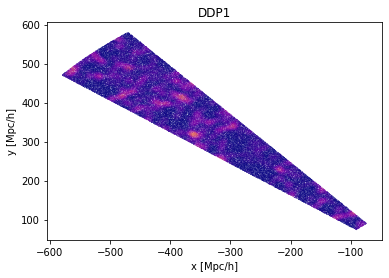

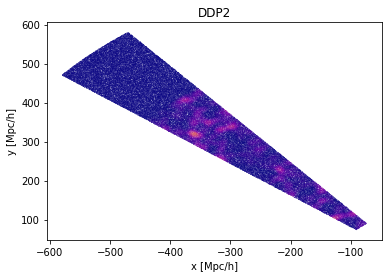

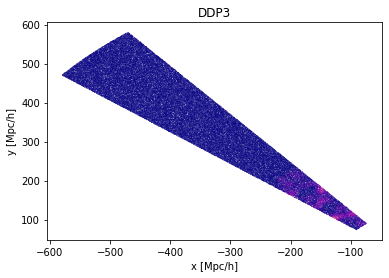

In [137]:
randoms_slice = randoms[np.abs(randoms['CARTESIAN_Z']) < 5.]

for idx in np.arange(1, 4, 1):
    plt.scatter(randoms_slice['CARTESIAN_X'],\
                randoms_slice['CARTESIAN_Y'],\
                c=randoms_slice['DDP{}_DELTA8'.format(idx)],\
                marker='.',\
                lw=0.0,\
                s=1,\
                vmin=-1.,\
                vmax=10.,\
                cmap='plasma')

    pl.xlabel('x [Mpc/h]')
    pl.ylabel('y [Mpc/h]')
    
    plt.title('DDP{}'.format(idx))
    plt.show()

In [138]:
findfile(ftype='ddp_n8_d0', field=field, utier=i, survey=survey)


'/cosma/home/durham/dc-moor2/data/GAMA4/gama_gold_G9_ddp_n8_d0_3.fits'

Text(0.5, 1.0, 'G9 GAMA Field')

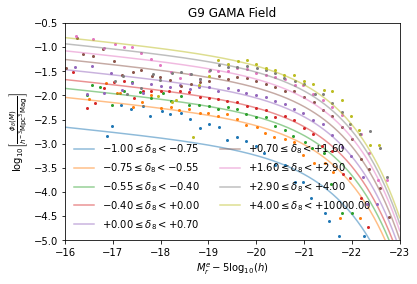

In [139]:
colors   = plt.rcParams['axes.prop_cycle'].by_key()['color']

# TO DO: take from header
for i in np.arange(0, 9, 1):
    #ddp  = Table.read(root + 'gama_gold_{}_ddp_n8_d0_{}.fits'.format(field, i))
    #vmax = Table.read(root + 'gama_gold_{}_ddp_n8_d0_{}_vmax.fits'.format(field, i), 'VMAX')
    #lf   = Table.read(root + 'gama_gold_{}_ddp_n8_d0_{}_lumfn.fits'.format(field, i), 'LUMFN')
    #ref  = Table.read(root + 'gama_gold_{}_ddp_n8_d0_{}_lumfn.fits'.format(field, i), 'REFERENCE')
    
    ddp   = Table.read(findfile(ftype='ddp_n8_d0', field=field, utier=i, survey=survey))
    vmax  = Table.read(findfile(ftype='ddp_n8_d0_vmax', field=field, utier=i, survey=survey), 'VMAX')
    lf  = Table.read(findfile(ftype='ddp_n8_d0_lumfn', field=field, utier=i, survey=survey), 'LUMFN')
    ref  = Table.read(findfile(ftype='ddp_n8_d0_lumfn', field=field, utier=i, survey=survey), 'REFERENCE')

    

    lf   = lf[lf['N'] > 0]

    lims = np.array(list(ddp.meta['D8{}LIMS'.format(i)][1:-1].split(','))).astype(np.float32)

    label = r'${:+.2f} \leq \delta_8 < {:+.2f}$'.format(lims[0], lims[1])

    pl.plot(ref['MS'], np.log10(ref['d{}_REFSCHECHTER'.format(i)]), label=label, alpha=0.5, c=colors[i])
    pl.plot(lf['MEDIAN_M'], np.log10(lf['PHI_IVMAX']), label='', marker='.', lw=0.0, c=colors[i], markersize=4)

plt.xlabel(r'$M_r^e - 5 \log_{10}(h)$')
plt.ylabel(r'$\log_{10} \left[ \frac{\phi_\delta(M)}{h^{-3} {\rm Mpc}^{3} {\rm Mag}^{}} \right] $')

pl.xlim(-16., -23.0)
pl.ylim(-5, -0.5)

pl.legend(frameon=False, loc=3, ncol=2, fontsize=10)
pl.title('{} GAMA Field'.format(field))

Text(0.5, 1.0, 'All GAMA Fields')

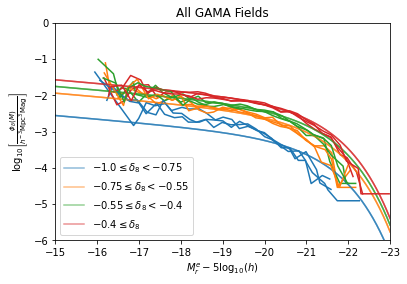

In [140]:
colors   = plt.rcParams['axes.prop_cycle'].by_key()['color']

for field in ['G9', 'G12', 'G15']:
    for i in np.arange(0, 4, 1):
        ddp  = Table.read(root + 'gama_gold_{}_ddp_n8_d0_{}.fits'.format(field, i))
        vmax = Table.read(root + 'gama_gold_{}_ddp_n8_d0_{}_vmax.fits'.format(field, i), 'VMAX')
        lf   = Table.read(root + 'gama_gold_{}_ddp_n8_d0_{}_lumfn.fits'.format(field, i), 'LUMFN')
        ref  = Table.read(root + 'gama_gold_{}_ddp_n8_d0_{}_lumfn.fits'.format(field, i), 'REFERENCE')

        lf   = lf[lf['N'] > 0]

        if field == 'G15':
            if i != 3:
                pl.plot(ref['MS'], np.log10(ref['d{}_REFSCHECHTER'.format(i)]), label=r'${} \leq \delta_8 < {}$'.format(d8_limits[i][0], d8_limits[i][1]), alpha=0.5, c=colors[i])
            else:
                pl.plot(ref['MS'], np.log10(ref['d{}_REFSCHECHTER'.format(i)]), label=r'${} \leq \delta_8$'.format(d8_limits[i][0]), alpha=0.5, c=colors[i])

        else:
            pl.plot(ref['MS'], np.log10(ref['d{}_REFSCHECHTER'.format(i)]), alpha=0.5, c=colors[i])

        pl.plot(lf['MEDIAN_M'], np.log10(lf['PHI_IVMAX']), label='', c=colors[i])

pl.xlabel(r'$M_r^e - 5 \log_{10}(h)$')
pl.ylabel(r'$\log_{10} \left[ \frac{\phi_\delta(M)}{h^{-3} {\rm Mpc}^{3} {\rm Mag}^{}} \right] $')

pl.xlim(-15., -23.0)
pl.ylim(-6,   0)

#pl.legend(frameon=False, loc=1, ncol=2)
pl.legend()
pl.title('All GAMA Fields')

(array([169., 216., 149., 194., 223., 170., 170., 210., 220., 226., 232.,
        174., 202., 202., 245., 255., 232., 176., 168., 190.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 [<matplotlib.patches.Polygon at 0x7fd59baf9370>])

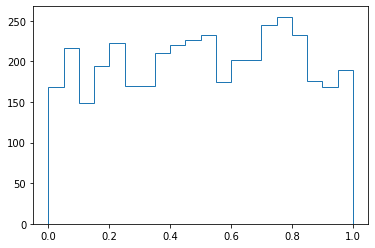

In [141]:
pl.hist(vmax['VZ'] / vmax['VMAX'], histtype='step', bins=np.arange(0., 1.01, 0.05))

In [142]:
lf.meta

OrderedDict([('VERSION', 'v46'),
             ('DATE', '2015-05-22'),
             ('AREA', '60.0'),
             ('GOLD_NGAL', '113687'),
             ('THETA_DEF', 'Z_THETA_QCOLOR'),
             ('DDP1_ZMIN', '0.0390699990093708'),
             ('DDP1_ZMAX', '0.2629899978637695'),
             ('DDP1_VZ', '7594754.153764196'),
             ('DDP1ZLIMS_NGAL', '113687'),
             ('DDP1_NGAL', '45293'),
             ('DDP1_DENS', '0.005963721679858641'),
             ('DDP2_ZMIN', '0.03914999961853027'),
             ('DDP2_ZMAX', '0.1937000006437302'),
             ('DDP2_VZ', '3156659.558717707'),
             ('DDP2ZLIMS_NGAL', '73942'),
             ('DDP2_NGAL', '33396'),
             ('DDP2_DENS', '0.01057953807776663'),
             ('DDP3_ZMIN', '0.03903000056743622'),
             ('DDP3_ZMAX', '0.1015800014138222'),
             ('DDP3_VZ', '457819.2340050841'),
             ('DDP3ZLIMS_NGAL', '18121'),
             ('DDP3_NGAL', '8842'),
             ('DDP3_DENS', '0.01

In [143]:
# fix to add column names

'''
colnames = ['M_R','LOGPHI']
TMR_d0 = Table.read('/cosma/home/durham/dc-moor2/DESI/data/TMR_d0', format='csv', names=colnames)
TMR_d1 = Table.read('/cosma/home/durham/dc-moor2/DESI/data/TMR_d1', format='csv', names=colnames)
TMR_d2 = Table.read('/cosma/home/durham/dc-moor2/DESI/data/TMR_d2', format='csv', names=colnames)
TMR_d3 = Table.read('/cosma/home/durham/dc-moor2/DESI/data/TMR_d3', format='csv', names=colnames)

plt.scatter(TMR_d0['M_R'], TMR_d0['LOGPHI'], marker='x')
plt.scatter(TMR_d1['M_R'], TMR_d1['LOGPHI'], marker='x')
plt.scatter(TMR_d2['M_R'], TMR_d2['LOGPHI'], marker='x')
plt.scatter(TMR_d3['M_R'], TMR_d3['LOGPHI'], marker='x')
'''

"\ncolnames = ['M_R','LOGPHI']\nTMR_d0 = Table.read('/cosma/home/durham/dc-moor2/DESI/data/TMR_d0', format='csv', names=colnames)\nTMR_d1 = Table.read('/cosma/home/durham/dc-moor2/DESI/data/TMR_d1', format='csv', names=colnames)\nTMR_d2 = Table.read('/cosma/home/durham/dc-moor2/DESI/data/TMR_d2', format='csv', names=colnames)\nTMR_d3 = Table.read('/cosma/home/durham/dc-moor2/DESI/data/TMR_d3', format='csv', names=colnames)\n\nplt.scatter(TMR_d0['M_R'], TMR_d0['LOGPHI'], marker='x')\nplt.scatter(TMR_d1['M_R'], TMR_d1['LOGPHI'], marker='x')\nplt.scatter(TMR_d2['M_R'], TMR_d2['LOGPHI'], marker='x')\nplt.scatter(TMR_d3['M_R'], TMR_d3['LOGPHI'], marker='x')\n"

In [144]:

Ms = np.arange(-25.5, -15.5 , 0.1)
bin_centres =  (Ms[1:]+Ms[:-1])/2
colour = ['blue', 'red', 'green', 'black']
'''
for idx in range(4):
    LF_G9  = Table.read(root + '{}_gold_G9_ddp_n8_d0_{}_lumfn.fits'.format(survey, idx), 'LUMFN')
    LF_G12 = Table.read(root + '{}_gold_G12_ddp_n8_d0_{}_lumfn.fits'.format(survey, idx), 'LUMFN')
    LF_G15 = Table.read(root + '{}_gold_G15_ddp_n8_d0_{}_lumfn.fits'.format(survey, idx), 'LUMFN')

    LF_G9_ref  = Table.read(root + 'gama_gold_G9_ddp_n8_d0_{}_lumfn.fits'.format(idx), 'REFERENCE')
    LF_G12_ref = Table.read(root + 'gama_gold_G12_ddp_n8_d0_{}_lumfn.fits'.format(idx), 'REFERENCE')
    LF_G15_ref = Table.read(root + 'gama_gold_G15_ddp_n8_d0_{}_lumfn.fits'.format(idx), 'REFERENCE')
    
    x =np.c_[bin_centres, np.array(LF_G9['PHI_IVMAX']), np.array(LF_G12['PHI_IVMAX']), np.array(LF_G15['PHI_IVMAX'])]
    x_ref=np.c_[LF_G9_ref['MS'], np.array(LF_G9_ref['d{}_REFSCHECHTER'.format(idx)]), np.array(LF_G12_ref['d{}_REFSCHECHTER'.format(idx)]), np.array(LF_G15_ref['d{}_REFSCHECHTER'.format(idx)])]

    LF_mean = np.mean(x[:,1:], axis=1)
    LF_std = np.std(x[:,1:], axis=1) / np.sqrt(3)

    LF_ref_mean = np.mean(x_ref[:,1:], axis=1)
    LF_ref_std = np.std(x_ref[:,1:], axis=1) / np.sqrt(3)
    
    pl.plot(bin_centres, np.log10(LF_mean), label='d{}'.format(idx), color=colour[idx])
    pl.plot(LF_G9_ref['MS'], np.log10(LF_ref_mean), alpha=0.5, color=colour[idx])
    #pl.errorbar(bin_centres, np.log10(LF_mean), np.log10(LF_std), label='d{}'.format(idx), color=colour[idx])
    
#plt.scatter(TMR_d0['M_R'], TMR_d0['LOGPHI'], marker='x', color='blue')
#plt.scatter(TMR_d1['M_R'], TMR_d1['LOGPHI'], marker='x', color='orange')
#plt.scatter(TMR_d2['M_R'], TMR_d2['LOGPHI'], marker='x', color='green')
#plt.scatter(TMR_d3['M_R'], TMR_d3['LOGPHI'], marker='x', color='black')

plt.xlabel(r'$M_r^e - 5 \log_{10}(h)$', fontsize=14)
plt.ylabel(r'$\log_{10} \left[ \frac{\phi_\delta(M)}{h^{-3} {\rm Mpc}^{3} {\rm Mag}^{}} \right] $')
plt.title(r'{} DDP LFs (All Fields)'.format(survey))

pl.ylim(-5.5, -.5)
pl.xlim(-22.5, -15.5)
pl.gca().invert_xaxis()
pl.gca().xaxis.set_major_locator(plt.MultipleLocator(1))

#pl.legend(frameon=True, loc=2)
pl.legend()
pl.show()
'''

"\nfor idx in range(4):\n    LF_G9  = Table.read(root + '{}_gold_G9_ddp_n8_d0_{}_lumfn.fits'.format(survey, idx), 'LUMFN')\n    LF_G12 = Table.read(root + '{}_gold_G12_ddp_n8_d0_{}_lumfn.fits'.format(survey, idx), 'LUMFN')\n    LF_G15 = Table.read(root + '{}_gold_G15_ddp_n8_d0_{}_lumfn.fits'.format(survey, idx), 'LUMFN')\n\n    LF_G9_ref  = Table.read(root + 'gama_gold_G9_ddp_n8_d0_{}_lumfn.fits'.format(idx), 'REFERENCE')\n    LF_G12_ref = Table.read(root + 'gama_gold_G12_ddp_n8_d0_{}_lumfn.fits'.format(idx), 'REFERENCE')\n    LF_G15_ref = Table.read(root + 'gama_gold_G15_ddp_n8_d0_{}_lumfn.fits'.format(idx), 'REFERENCE')\n    \n    x =np.c_[bin_centres, np.array(LF_G9['PHI_IVMAX']), np.array(LF_G12['PHI_IVMAX']), np.array(LF_G15['PHI_IVMAX'])]\n    x_ref=np.c_[LF_G9_ref['MS'], np.array(LF_G9_ref['d{}_REFSCHECHTER'.format(idx)]), np.array(LF_G12_ref['d{}_REFSCHECHTER'.format(idx)]), np.array(LF_G15_ref['d{}_REFSCHECHTER'.format(idx)])]\n\n    LF_mean = np.mean(x[:,1:], axis=1)\n    LF_

/tmp/ipykernel_166017/3883316098.py:28: RuntimeWarning: divide by zero encountered in log10
  pl.plot(LF_G9_ref['MS'], np.log10(LF_mean), label=label[idx], color=colour[idx])
/tmp/ipykernel_166017/3883316098.py:28: RuntimeWarning: divide by zero encountered in log10
  pl.plot(LF_G9_ref['MS'], np.log10(LF_mean), label=label[idx], color=colour[idx])
/tmp/ipykernel_166017/3883316098.py:28: RuntimeWarning: divide by zero encountered in log10
  pl.plot(LF_G9_ref['MS'], np.log10(LF_mean), label=label[idx], color=colour[idx])
/tmp/ipykernel_166017/3883316098.py:28: RuntimeWarning: divide by zero encountered in log10
  pl.plot(LF_G9_ref['MS'], np.log10(LF_mean), label=label[idx], color=colour[idx])


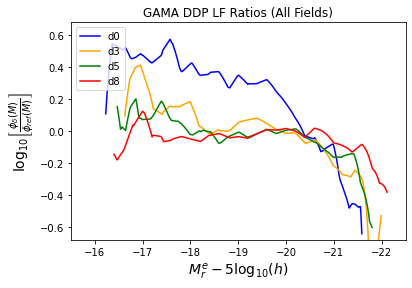

In [147]:
colour = ['blue', 'orange', 'green', 'red']
label  = ['d0', 'd3', 'd5', 'd8']

for idx in range(4):
    LF_G9  = Table.read(root + 'gama_gold_G9_ddp_n8_d0_{}_lumfn.fits'.format(idx))
    LF_G12 = Table.read(root + 'gama_gold_G12_ddp_n8_d0_{}_lumfn.fits'.format(idx))
    LF_G15 = Table.read(root + 'gama_gold_G15_ddp_n8_d0_{}_lumfn.fits'.format(idx))

    LF_G9_ref  = Table.read(root + 'gama_gold_G9_ddp_n8_d0_{}_lumfn.fits'.format(idx), 'REFERENCE')
    LF_G12_ref = Table.read(root + 'gama_gold_G12_ddp_n8_d0_{}_lumfn.fits'.format(idx), 'REFERENCE')
    LF_G15_ref = Table.read(root + 'gama_gold_G15_ddp_n8_d0_{}_lumfn.fits'.format(idx), 'REFERENCE')
    
    LF_G9_curve = interp1d(LF_G9['MEDIAN_M'], LF_G9['PHI_IVMAX'], kind='linear', copy=True, bounds_error=False, fill_value=0.0, assume_sorted=False)
    LF_G12_curve = interp1d(LF_G12['MEDIAN_M'], LF_G12['PHI_IVMAX'], kind='linear', copy=True, bounds_error=False, fill_value=0.0, assume_sorted=False)
    LF_G15_curve = interp1d(LF_G15['MEDIAN_M'], LF_G15['PHI_IVMAX'], kind='linear', copy=True, bounds_error=False, fill_value=0.0, assume_sorted=False)

    x=np.c_[LF_G9_ref['MS'], np.array(LF_G9_curve(LF_G9_ref['MS'])/LF_G9_ref['d{}_REFSCHECHTER'.format(idx)]), np.array(LF_G12_curve(LF_G12_ref['MS'])/LF_G12_ref['d{}_REFSCHECHTER'.format(idx)]), np.array(LF_G15_curve(LF_G15_ref['MS'])/LF_G15_ref['d{}_REFSCHECHTER'.format(idx)])]

    #x_ref=np.c_[bin_centres, np.array(LF_G9['d{}_REFSCHECHTER'.format(idx)]), np.array(LF_G12['d{}_REFSCHECHTER'.format(idx)]), np.array(LF_G15['d{}_REFSCHECHTER'.format(idx)])]
    #x=np.c_[bin_centres, np.array(LF_G9['PHI_IVMAX']/LF_G9['d{}_REFSCHECHTER'.format(idx)]), np.array(LF_G12['PHI_IVMAX']/LF_G12['d{}_REFSCHECHTER'.format(idx)]), np.array(LF_G15['PHI_IVMAX']/LF_G15['d{}_REFSCHECHTER'.format(idx)])]

    LF_mean = np.mean(x[:,1:], axis=1)
    LF_std = np.std(x[:,1:], axis=1) / np.sqrt(3)

    #LF_ref_mean = np.mean(x_ref[:,1:], axis=1)
    #LF_ref_std = np.std(x_ref[:,1:], axis=1) / np.sqrt(3)
    
    pl.plot(LF_G9_ref['MS'], np.log10(LF_mean), label=label[idx], color=colour[idx])
    #pl.plot(bin_centres, np.log10(LF_ref_mean), alpha=0.5, color=colour[idx])
    #pl.errorbar(bin_centres, np.log10(LF_mean), np.log10(LF_std), label='d{}'.format(idx))
    
    #pl.errorbar(gama_lf['MEDIAN_M'], np.log10(gama_lf['PHI_N']), gama_lf['PHI_N_ERROR'] / gama_lf['PHI_N'] / np.log(10.), label='NOWEIGHT', alpha=0.4)
    #pl.errorbar(gama_lf['MEDIAN_M'], np.log10(gama_lf['PHI_IVMAX']), gama_lf['PHI_IVMAX_ERROR'] / gama_lf['PHI_IVMAX'] / np.log(10.), label='IVMAX')
    
plt.xlabel(r'$M_r^e - 5 \log_{10}(h)$', fontsize=14)
plt.ylabel(r'$\log_{10} \left[ \frac{\phi_\delta(M)}{\phi_{ref}(M)} \right]$', fontsize=14)
plt.title(r'{} DDP LF Ratios (All Fields)'.format(survey.upper()))

#pl.ylim(-4.25, -.75)
pl.xlim(-22.5, -15.5)
pl.ylim(-0.68, 0.68)
pl.gca().invert_xaxis()

pl.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
pl.gca().yaxis.set_major_locator(plt.MultipleLocator(0.2))

pl.legend(frameon=True, loc=2)
pl.show()

# Done.